In [1]:
from pymongo import MongoClient
from datetime import datetime
import sys
import os
import pandas as pd
from time import time
import matplotlib.pyplot as plt

In [2]:
forum = 'overflow'
print(f'Forum: {forum}')

client = MongoClient()
db = client.titlewave
posts = db[f'{forum}.posts']

total_posts = posts.count_documents({})
print(f'{total_posts} posts found...')

Forum: overflow
20511138 posts found...


In [3]:
# Count posts by year
start_time = time()
result = posts.aggregate([{'$group': {'_id': {'$year': '$CreationDate'},
                                      'NumPosts': {'$sum': 1},
                                      'AvgViews': {'$avg': '$ViewCount'},
                                      'AnswerProbability': {'$avg': {'$cond': [{'$gt': ['$AnswerCount', 0]}, 1, 0]}}}},
                          {'$sort': {'_id': 1}}
                          ])
result = list(result)
df = pd.DataFrame(result)
print(f'Duration: {time() - start_time:.2f} s')
df

Duration: 54.79 s


,_id,NumPosts,AvgViews,AnswerProbability
0,2008,57901,31088.317179,0.998722
1,2009,342464,13400.255043,0.996373
2,2010,692099,8065.688352,0.990237
3,2011,1192278,6016.628982,0.975086
4,2012,1633033,4547.070467,0.950124
5,2013,2044651,3644.945315,0.920695
6,2014,2150802,2199.047649,0.888479
7,2015,2205883,1693.626195,0.867283
8,2016,2208518,1446.900250,0.850769
9,2017,2124351,1193.564861,0.834979


In [28]:
def mongo_query(start_date, end_date, exclude_closed):
    """Create a MongoDB query based on a set of conditions."""
    query = {}
    if start_date:
        if not ('CreationDate' in query):
            query['CreationDate'] = {}
        query['CreationDate']['$gte'] = start_date
    if end_date:
        if not ('CreationDate' in query):
            query['CreationDate'] = {}
        query['CreationDate']['$lt'] = end_date
    if exclude_closed:
        query['Closed'] = False
    return query
def single_year_query(year):
    return mongo_query(start_date=datetime(year, 1, 1),
                        end_date=datetime(year+1, 1, 1),
                        exclude_closed=True)

In [29]:
# Count posts in a specific year by month
start_time = time()
result = posts.aggregate([{'$match': single_year_query(2018)},
                          {'$group': {'_id': {'$month': '$CreationDate'},
                                      'NumPosts': {'$sum': 1},
                                      'AvgViews': {'$avg': '$ViewCount'},
                                      'AnswerProbability': {'$avg': {'$cond': [{'$gt': ['$AnswerCount', 0]}, 1, 0]}}}},
                          {'$sort': {'_id': 1}}
                          ])
result = list(result)
df = pd.DataFrame(result)
print(f'Duration: {time() - start_time:.2f} s')
df

Duration: 4.51 s


,_id,NumPosts,AvgViews,AnswerProbability
0,1,154173,1020.928074,0.834329
1,2,147430,943.979502,0.833175
2,3,166838,909.466057,0.827234
3,4,156678,900.945991,0.825304
4,5,161826,886.094385,0.821648
5,6,149476,871.385942,0.823075
6,7,154561,825.644568,0.823914
7,8,153219,770.402581,0.825152
8,9,139386,738.099788,0.826374
9,10,155528,662.491738,0.827349


In [30]:
# Analyze posts by title length
start_time = time()
result = posts.aggregate([{'$match': single_year_query(2018)},
                          {'$group': {'_id': {'$strLenCP': '$Title'},
                                      'NumPosts': {'$sum': 1},
                                      'AvgViews': {'$avg': '$ViewCount'},
                                      'AnswerProbability': {'$avg': {'$cond': [{'$gt': ['$AnswerCount', 0]}, 1, 0]}}}},
                          {'$sort': {'_id': 1}}
                          ])
result = list(result)
df = pd.DataFrame(result)
print(f'Duration: {time() - start_time:.2f} s')

Duration: 3.55 s


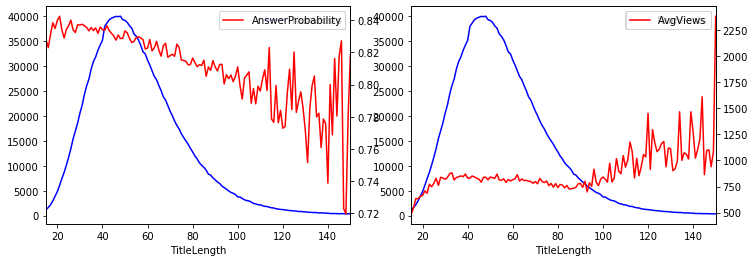

In [31]:
# Plot the results for view counts (TODO: median would be less noisy)
df = df.rename(columns={'_id': 'TitleLength'})
fig, (ax1, ax2) = plt.subplots(1,2, figsize=[12,4])
df.plot(x='TitleLength', y='NumPosts', ax = ax1, color='blue')
df.plot(x='TitleLength', y='AnswerProbability', ax = ax1.twinx(), color='red')
df.plot(x='TitleLength', y='NumPosts', ax = ax2, color='blue')
df.plot(x='TitleLength', y='AvgViews', ax = ax2.twinx(), color='red')
plt.show()

In [8]:
# Analyze posts by tag

start_time = time()
result = posts.aggregate([{'$project': {'Title': False, 'Body': False}},
                          {'$unwind': '$Tags'},
                          {'$group': {'_id': '$Tags',
                                      'NumPosts': {'$sum': 1},
                                      'AvgViews': {'$avg': '$ViewCount'},
                                      'AnswerProbability': {'$avg': {'$cond': [{'$gt': ['$AnswerCount', 0]}, 1, 0]}}}},
                          {'$sort': {'NumPosts': -1}}
                          ])
result = list(result)
df = pd.DataFrame(result)
print(f'Duration: {time() - start_time:.2f} s')
df.head(20)


Duration: 70.93 s


,_id,NumPosts,AvgViews,AnswerProbability
0,javascript,2130666,2462.468638,0.862712
1,java,1735376,3000.024309,0.859456
2,python,1597776,2743.047545,0.843898
3,c#,1450789,2738.560356,0.871949
4,php,1381587,1966.313172,0.872562
5,android,1311753,2488.909118,0.825064
6,html,1038300,2725.140127,0.887280
7,jquery,1002517,2707.773122,0.893397
8,c++,702920,2294.819290,0.882073
9,css,694900,2987.690311,0.898466
